# Converting graphs to deep learning datasets

PyTorch, and by extension PyTorch-Geometric, has some standardized ways of handling data and datasets. We first need to make a torch `Data` object from our graphs, with graphein's conversion functions

In [1]:
import graphein
from graphein.ml import GraphFormatConvertor
graphein.verbose(enabled=False)
from src import dataloader
import torch
import warnings
warnings.filterwarnings("ignore")

[03/04/24 15:34:50] WARNING  To use the Graphein submodule                                         ]8;id=635037;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=230819;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#45\45]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[03/04/24 15:34:56] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=755665;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=369310;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/visualisation.py#36\36]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=544146;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=3993;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/meshes.py#30\30]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

## Data objects 

We first need to make a torch `Data` object from our graphs. This is easily done with graphein's conversion functions, specifically the `GraphFormatConvertor` object.

In [2]:
GraphFormatConvertor??

Init signature:
GraphFormatConvertor(
    src_format: 'str',
    dst_format: 'str',
    verbose: 'SUPPORTED_VERBOSITY' = 'gnn',
    columns: 'Optional[List[str]]' = None,
)
Source:        
class GraphFormatConvertor:
    """
    Provides conversion utilities between NetworkX Graphs and geometric deep learning library destination formats.
    Currently, we provide support for converstion from ``nx.Graph`` to ``dgl.DGLGraph`` and ``pytorch_geometric.Data``. Supported conversion
    formats can be retrieved from :const:`~graphein.ml.conversion.SUPPORTED_FORMATS`.

    :param src_format: The type of graph you'd like to convert from. Supported formats are available in :const:`~graphein.ml.conversion.SUPPORTED_FORMATS`
    :type src_format: Literal["nx", "pyg", "dgl", "jraph"]
    :param dst_format: The type of graph format you'd like to convert to. Supported formats are available in:
        ``graphein.ml.conversion.SUPPORTED_FORMATS``
    :type dst_format:  Literal["nx", "pyg", "dgl", "jra

By specifying the columns below we make sure that our node features are present in the torch `Data` object. We also add in the edge kind ("kind") edge attribute, which says if the edge is a peptide bond, distance edge etc. While this can't be used directly for training as it's a string, it can be used for filtering and other pre-processing steps.

In [3]:
columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "sasa"
]

convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)

n order to train our model, we also need to map the interface labels we calculated to the node_ids as our "target". We'll store these in the `data.y` attribute. The node features that we want to use will be stacked and stored in `data.x`

In [4]:
def graphein_to_torch_graph(graphein_graph, interface_labels, convertor, 
                            node_attr_columns = ["amino_acid_one_hot", "meiler"]):
    """
    Converts a Graphein graph to a pytorch-geometric Data object.
    """
    data = convertor(graphein_graph)
    data_dict= data.to_dict()
    x_data = []
    for x in node_attr_columns:
        if data_dict[x].ndim == 1:  #if we want to include solvent accesible area, which is one-dimensional
            x_data.append(torch.atleast_2d(data_dict[x]).T)
        else:
            x_data.append(torch.atleast_2d(data_dict[x]))
    data.x = torch.hstack(x_data).float() # Concatenate the node attributes and convert to float
    data.pos = data.coords.float() # We also save the 3D coordinates as node positions
    data.y = torch.zeros(data.num_nodes) # Interface labels
    for i, node_id in enumerate(data.node_id):
        if node_id in interface_labels:
            data.y[i] = 1
    return data

In [5]:
graphein_graph, interface_labels = dataloader.load_graph("1A0G", "A")
torch_geometric_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor)

In [6]:
torch_geometric_graph

Data(edge_index=[2, 2746], node_id=[280], chain_id=[280], residue_number=[280], coords=[280, 3], amino_acid_one_hot=[280, 20], meiler=[280, 7], sasa=[280], kind=[1373], num_nodes=280, x=[280, 27], pos=[280, 3], y=[280])

In [7]:
torch_geometric_graph.edge_index.T

tensor([[  0,  27],
        [  0,  41],
        [  0,  83],
        ...,
        [279, 248],
        [279, 251],
        [279, 267]])

In [8]:
torch_geometric_graph.node_id

['A:ILE:137',
 'A:THR:227',
 'A:THR:84',
 'A:ARG:59',
 'A:GLY:259',
 'A:GLY:178',
 'A:ILE:87',
 'A:LEU:154',
 'A:ILE:200',
 'A:ARG:206',
 'A:GLU:13',
 'A:ASP:67',
 'A:PHE:225',
 'A:GLU:126',
 'A:GLU:158',
 'A:LYS:108',
 'A:ASN:217',
 'A:THR:95',
 'A:VAL:129',
 'A:LEU:82',
 'A:ASN:148',
 'A:GLY:94',
 'A:GLN:157',
 'A:THR:241',
 'A:THR:176',
 'A:ASN:105',
 'A:ASP:21',
 'A:GLU:135',
 'A:ASN:214',
 'A:ARG:141',
 'A:VAL:261',
 'A:HIS:47',
 'A:HIS:70',
 'A:GLY:113',
 'A:ALA:99',
 'A:GLY:253',
 'A:LYS:202',
 'A:SER:181',
 'A:VAL:248',
 'A:LEU:150',
 'A:THR:193',
 'A:TRP:139',
 'A:ILE:216',
 'A:LYS:221',
 'A:ASP:234',
 'A:TRP:264',
 'A:PHE:133',
 'A:GLU:14',
 'A:ILE:60',
 'A:ARG:22',
 'A:VAL:77',
 'A:GLN:90',
 'A:ARG:93',
 'A:LYS:116',
 'A:SER:146',
 'A:LYS:156',
 'A:LYS:267',
 'A:PRO:103',
 'A:ILE:190',
 'A:GLU:235',
 'A:ALA:155',
 'A:LEU:51',
 'A:THR:226',
 'A:TYR:31',
 'A:THR:106',
 'A:ASN:6',
 'A:LYS:66',
 'A:ASP:143',
 'A:GLY:23',
 'A:THR:265',
 'A:LEU:122',
 'A:VAL:15',
 'A:PRO:224',
 'A

In [9]:
torch_geometric_graph.kind

[{'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distanc

Visualization of amino acid types and solvent accessible area across interface and non-interface residues.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

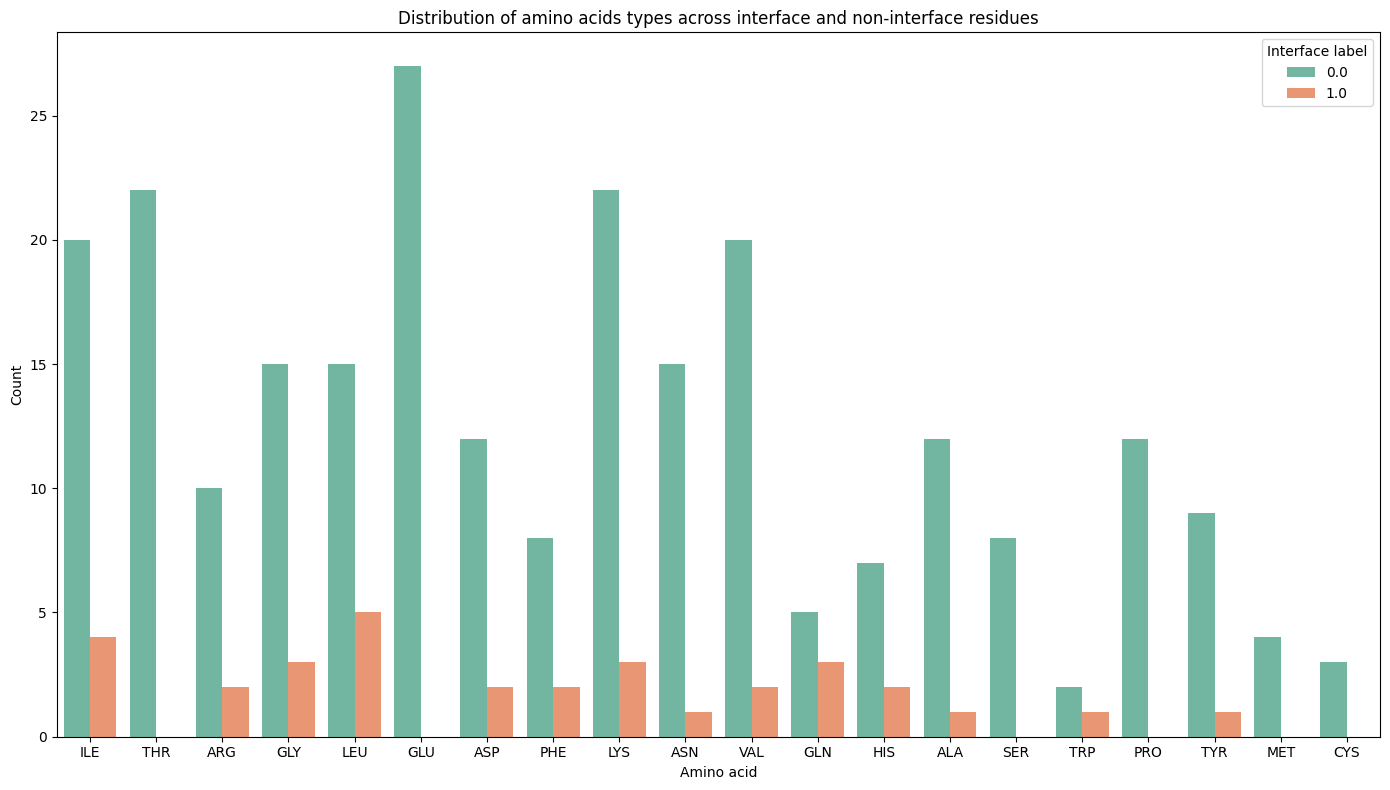

In [11]:
extracted_amino_acids = [s.split(":")[1] for s in torch_geometric_graph.node_id]

data_with_aa = {"amino acid": extracted_amino_acids, "interface labels": torch_geometric_graph.y}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

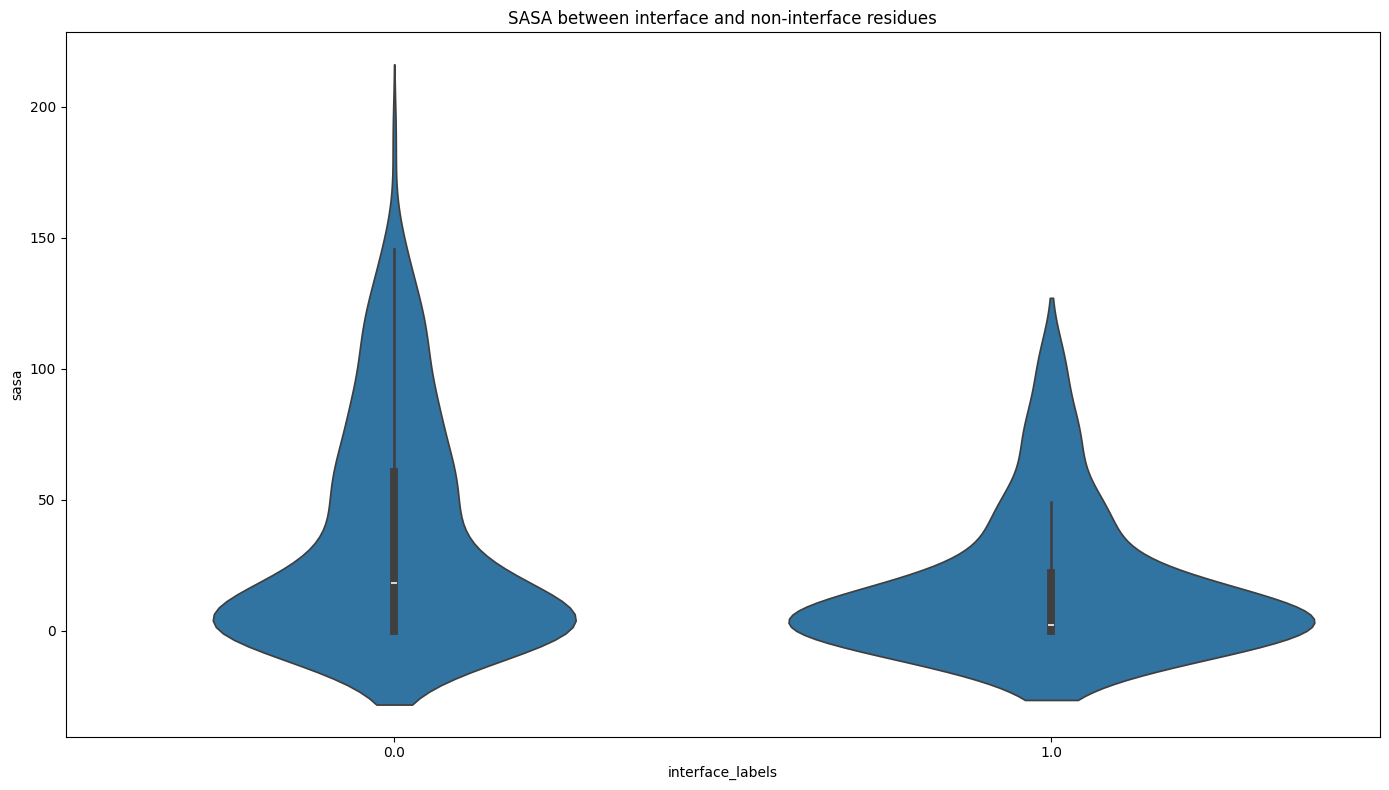

In [12]:
data = {
    "sasa": torch_geometric_graph.sasa,
    "interface_labels": torch_geometric_graph.y
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

## Creating a Dataset class

The `torch_geometric.data.Dataset` class is a standard way of representing a graph dataset in PyTorch. It is an abstract class that you can subclass to create your own dataset. Here's what the tyical architecture of a dataset looks like ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset)):

- download(): function to download the dataset (in our case from `dataset.txt`) and saves it in `self.raw_dir` (in our case as a graphein graph and interface labels)
- process(): function to process the data from `self.raw_dir` to torch-geometric `Data` objects, saved in `self.processed_dir`
- property functions: raw_file_names, processed_file_names which return the names of the raw and processed files
- len(): function to return the number of graphs in the dataset
- get(): function to return the `Data` object at a given index

In [13]:
from torch_geometric.data import Dataset
from pathlib import Path
import pickle
import torch

class ProteinDataset(Dataset):
    """
    torch-geometric Dataset class for loading protein files as graphs.
    """
    def __init__(self, root,
                 protein_names: list):
        columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "sasa"
        ]
        self.convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)
        self.protein_names = protein_names
        super(ProteinDataset, self).__init__(root)

    def download(self):
        for protein_name in self.protein_names:
            output = Path(self.raw_dir) / f'{protein_name}.pkl'
            if not output.exists():
                pdb_id, chain = protein_name.split("_")
                graphein_graph, interface_labels = dataloader.load_graph(pdb_id, chain)
                with open(output, "wb") as f:
                    pickle.dump((graphein_graph, interface_labels), f)

    @property
    def raw_file_names(self):
        return [Path(self.raw_dir) / f"{protein_name}.pkl" for protein_name in self.protein_names if (Path(self.raw_dir) / f"{protein_name}.pt").exists()]

    @property
    def processed_file_names(self):
        return [Path(self.processed_dir) / f"{protein_name}.pt" for protein_name in self.protein_names if (Path(self.processed_dir) / f"{protein_name}.pt").exists()]

    def process(self):
        for protein_name in self.protein_names:
            output = Path(self.processed_dir) / f'{protein_name}.pt'
            if not output.exists():
                with open(Path(self.raw_dir) / f"{protein_name}.pkl", "rb") as f:
                    graphein_graph, interface_labels = pickle.load(f)
                torch_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor=self.convertor)
                torch.save(torch_graph, output)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(self.processed_file_names[idx])
        return data


Let's make our dataset!

In [ ]:
with open('dataset.txt') as f:
    protein_names = [line.strip() for line in f]



In [14]:
with open('dataset.txt') as f:
    protein_names = [line.strip() for line in f]

valid_protein_names = []

for protein_name in protein_names:
    print(protein_name)
    try:
        protein_name = [protein_name]
        dataset = ProteinDataset(root='./test_data', protein_names=protein_name)
        valid_protein_names.append(protein_name[0])
    
    except Exception as e:
        print(f"Error processing {protein_name[0]}: {e}")

print(len(valid_protein_names))
with open('valid_protein_names.txt', 'w') as f:
    for name in valid_protein_names:
        f.write(f"{name}\n")


Processing...
Done!


2D1P_G
2D1P_G


Processing...
Done!


2D2A_A
2D2A_A


Processing...
Done!


2D42_B
2D42_B


Processing...
Done!


2D4C_B
2D4C_B


Processing...
Done!


2D4U_A
2D4U_A


Processing...
Done!


2D8D_B
2D8D_B


Processing...
Done!


2DB4_B
2DB4_B


Processing...
Done!


2DB7_A
2DB7_A


Processing...
Done!


2DD4_C
2DD4_C


Processing...
Done!


2DD5_J
2DD5_J


Processing...
Done!


2DDK_A
2DDK_A


Processing...
Done!


2DDM_B
2DDM_B


Processing...
Done!


2DDZ_B
2DDZ_B


Processing...
Done!


2DE5_E
2DE5_E


Processing...
Done!


2DI3_A
2DI3_A


Processing...
Done!


2DJF_A
2DJF_A


Processing...
Done!


2DM9_B
2DM9_B


Processing...
Done!


2DOI_X
2DOI_X


Processing...
Done!


2DPF_D
2DPF_D


Processing...
Done!


2DPP_B
2DPP_B


Processing...
Done!


2DSP_B
2DSP_B


Processing...
Done!


2DT5_B
2DT5_B


Processing...
Done!


2DUM_C
2DUM_C


Processing...
Done!


2DUP_A
2DUP_A


Processing...
Done!


2DVT_A
2DVT_A


Processing...
Done!


2DWN_C
2DWN_C


Processing...
Done!


2DX7_B
2DX7_B


Processing...
Done!


2DXB_H
2DXB_H


Processing...
Done!


2DYM_G
2DYM_G


KeyboardInterrupt: 

In [15]:
dataset

ProteinDataset(100)

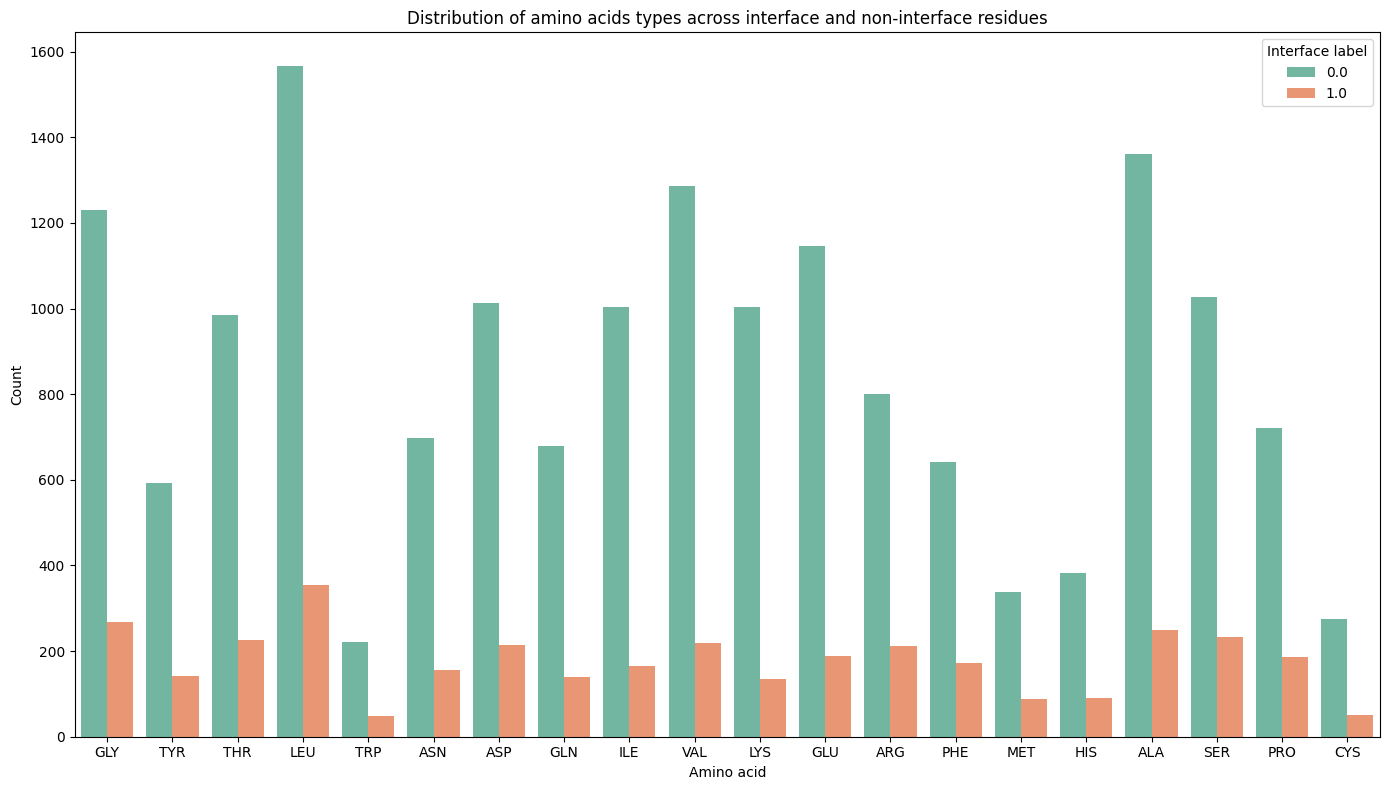

In [16]:
all_amino_acids = []
all_interface_labels = []

for torch_graph in dataset:
    extracted_amino_acids = [s.split(":")[1] for s in torch_graph.node_id]
    all_amino_acids.extend(extracted_amino_acids)
    all_interface_labels.extend(torch_graph.y.tolist())

data_with_aa = {
    "amino acid": all_amino_acids,
    "interface labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

In [17]:
sasa = []
all_interface_labels = []

for torch_graph in dataset:
    sasa.extend(torch_graph.sasa.tolist())
    all_interface_labels.extend(torch_graph.y.tolist())

data = {
    "sasa": sasa,
    "interface_labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

AttributeError: 'GlobalStorage' object has no attribute 'sasa'

In [ ]:
# TODO: add functions to src/dataloader.py

This puts together what we've been implementing for loading proteins as graphs with graphein, converting those into PyTorch-geometric Data objects and then wrapping those into a PyTorch Dataset. 

Graphein also has a built-in `ProteinGraphDataset` class that combines these steps. It also has some nice features like (1) the ability to load a dataset of proteins from both the PDB or AlphaFold Database directory of PDB files, (2) the ability to apply custom transformations from your bioinformatics tools of choice to the PDB files (with the `pdb_transform` argument).

# Creating Lightning Data Module

Now that we have our `Dataset` module ready, we need to specificy how these `Data` objects within the created Dataset are split into training, validation and test sets. This is where PyTorch Lightning's DataModule comes in ([documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)). The `DataModule` is a class that encapsulates the logic for loading, batching and splitting the data. It's a way of keeping the data loading and batching logic separate from the model and training logic, which makes the code more modular and easier to maintain. It also makes it easier to switch between different datasets and data loading strategies.

To define a `DataModule` the following methods are used to create train/val/test/predict dataloaders:
- prepare_data (how to download, tokenize, etc…)
- setup (how to split, define dataset, etc…), also expects `stage` argument (one of `fit,validate,test,predict`) 
- train_dataloader
- val_dataloader
- test_dataloader
- predict_dataloader

In [ ]:
import lightning as L
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from src import dataloader

class ProteinGraphDataModule(L.LightningDataModule):
    def __init__(self, root, dataset_file):
        super().__init__()
        self.root = root
        self.dataset_file = dataset_file
        with open(dataset_file) as f:
            self.protein_names = [line.strip() for line in f]
        self.protein_names = self.protein_names[:100] # SMALL DATASET FOR TESTING

    def prepare_data(self):
        # download, IO, etc. Useful with shared filesystems
        # only called on 1 GPU/TPU in distributed settings
        # does the downloading and saving of graphein graphs part, just once
        dataloader.ProteinDataset(root=self.root,
                                  protein_names=self.protein_names)
    

    def setup(self, stage):
        # make assignments here (val/train/test split)
        # called on every process in DDP
        # now it's just loaded and not downloaded processed etc.
        # stage(str) – either 'fit', 'validate', 'test', or 'predict'
        dataset = dataloader.ProteinDataset(root=self.root,
                                            protein_names=self.protein_names)
        train_idx, val_idx, test_idx = random_split(range(len(dataset)), [0.8, 0.1, 0.1])
        self.train, self.val, self.test = dataset[list(train_idx)], dataset[list(val_idx)], dataset[list(test_idx)]

    def train_dataloader(self):
        return DataLoader(self.train)

    def val_dataloader(self):
        return DataLoader(self.val)

    def test_dataloader(self):
        return DataLoader(self.test)

As you can see in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader) of pytorch geometric data loader, there are few parameters we didn't use: batch_size, shuffle and num_workers.
Batch size is the number of training examples in each iteration of the process (one forward and backward pass). It affects the speed of the training and generalizability of the model.

A batch, in a graph neural network sense, essentially combines all the graphs of the individual proteins into a bigger batch graph, with an additional batch attribute that specifies which protein each node belongs to. Since there are no edges between the different proteins, training on this batch graph is equivalent to training on the individual graphs separately, since no information flows between the different proteins.

In [ ]:
#TODO: include batch size in the dataloader, num_workers and shuffle in the dataloader

In [ ]:
class ProteinGraphDataModule(L.LightningDataModule):
    def __init__(self, root, dataset_file, batch_size=8, num_workers=4):
        super().__init__()
        self.root = root
        self.dataset_file = dataset_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        with open(dataset_file) as f:
            self.protein_names = [line.strip() for line in f]
        self.protein_names = self.protein_names[:100] # SMALL DATASET FOR TESTING

    def prepare_data(self):
        # download, IO, etc. Useful with shared filesystems
        # only called on 1 GPU/TPU in distributed settings
        # does the downloading and saving of graphein graphs part, just once
        ProteinDataset(root=self.root,
                        protein_names=self.protein_names)
    

    def setup(self, stage):
        # make assignments here (val/train/test split)
        # called on every process in DDP
        # now it's just loaded and not downloaded processed etc.
        # stage one of 
        dataset = ProteinDataset(root=self.root,
                                  protein_names=self.protein_names)
        train_idx, val_idx, test_idx = random_split(range(len(dataset)), [0.8, 0.1, 0.1])
        self.train, self.val, self.test = dataset[list(train_idx)], dataset[list(val_idx)], dataset[list(test_idx)]

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

`DataModule` is now read, give it a try and loop through the dataloader to see how, they work!

In [ ]:
# TODO: loop through the dataloaders
# TODO: add functions to src/dataloader.py

In [ ]:
datamodule = ProteinGraphDataModule("./test_data", "dataset.txt")
datamodule.prepare_data()
datamodule.setup("fit")

train_loader = datamodule.train_dataloader()
example_train_batch = next(iter(train_loader))
example_train_protein = datamodule.train[0]

We have an example train data point (`example_train_protein`) but training is almost always done on batches of data points. This is what is returned by the `train_dataloader` of the `DataModule`, in `example_train_batch`. Let's check what each of variables contain.

In [ ]:
example_train_protein

In [ ]:
example_train_batch